# Predicting Heart Disease
The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, I will use the [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) dataset and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future.

In [1]:
#import libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA: Descriptive Statistics
We will start with exploring our dataset. As per the source, each patient has the following information collected about them:

- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

In [2]:
#load dataset
df = pd.read_csv('heart_disease_prediction.csv')

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.



In [4]:
print(df.dtypes)
df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
dtype: int64

`7` features in total are numerical while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease` are categorical as well.



In [5]:
df.describe()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


It is observed that:
- The average age of patients is ~53 years.
- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- RestingBP and Cholesterol have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

`RestingBP` can't be 0. And, as per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol is a composite of different measurements. So, it is unlikely that Cholesterol would be 0 as well. I will have to clean both of these up later.

Next, i will look at the categorical variables. It would also be beneficial to look at how the target feature, HeartDisease, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.


In [6]:
#looking for missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset!

## EDA: Visualizations

Let's start looking at the categories in more detail.

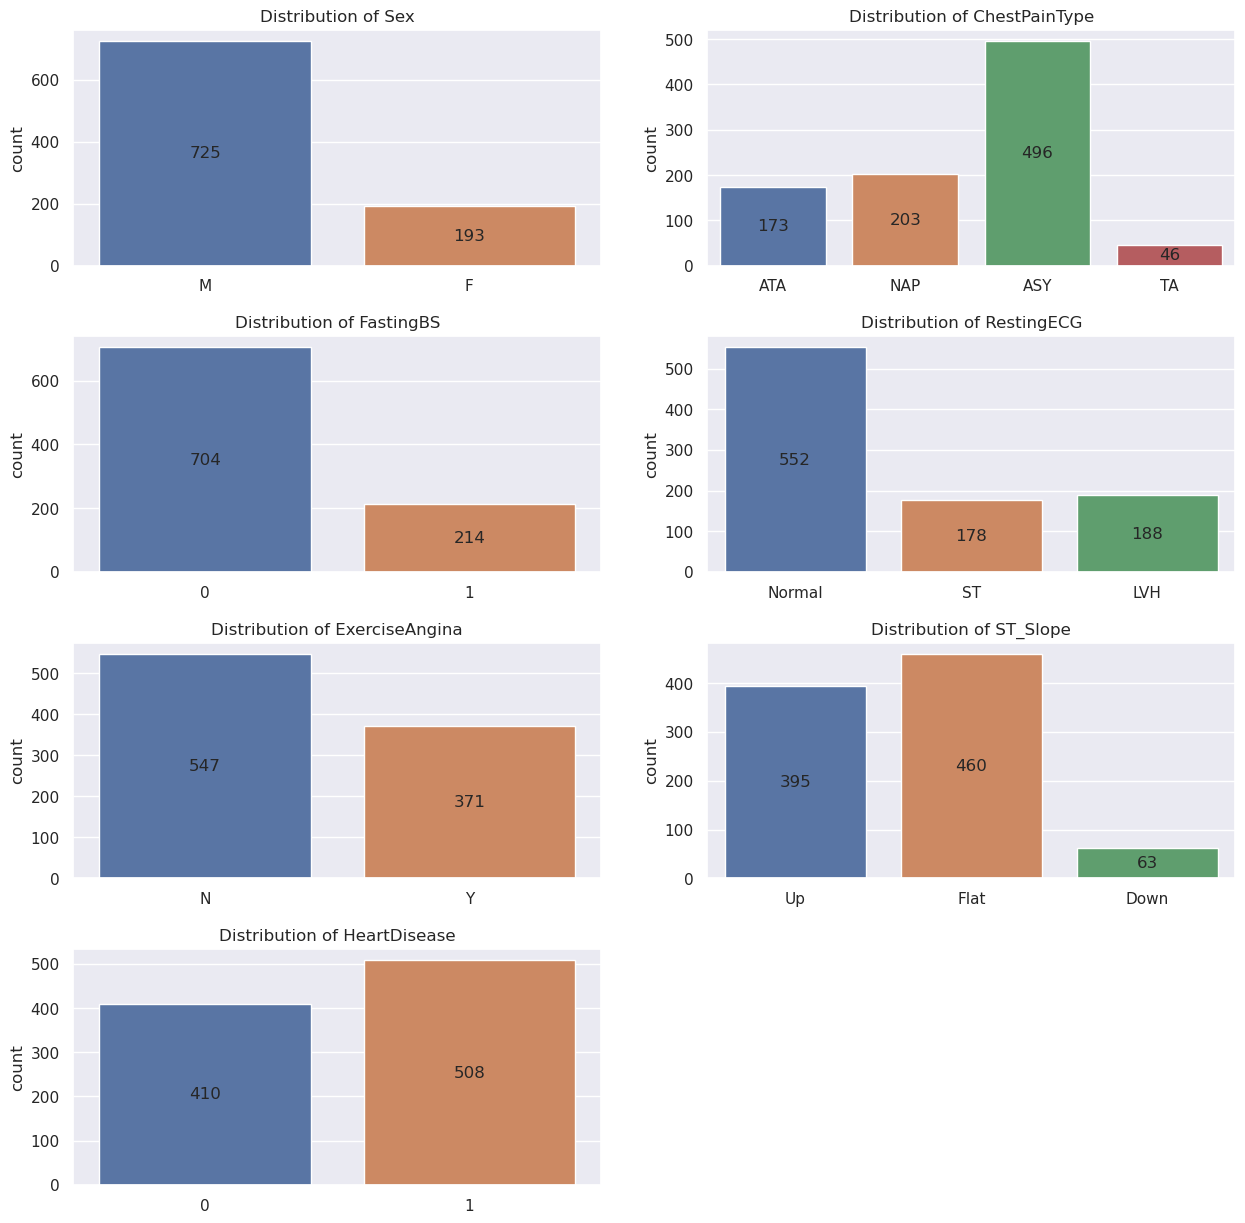

In [7]:
cat_vars = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(15,15))
sns.set_theme()
for ind, cat in enumerate(cat_vars):
    ax = fig.add_subplot(4,2,ind+1)
    sns.countplot(data=df, x=cat, ax=ax)
    ax.bar_label(ax.containers[0], label_type='center')
    ax.set_title(f"Distribution of {cat}")
    ax.set_xlabel('')
#     print(cat)
    

plt.subplots_adjust(hspace=0.3)
plt.show()


The insights found from the above visualizations are the following:
- The dataset is highly skewed towards male patients. 725 rows correspond to male patients, whereas only 193 correspond to female patients. This could potentially induce a bias in our model and impact predictions for any female patients in any unseen data.
- Most the patients have ASY chest pain type with 496 patients and only 46 patients have TA chest pain type
- 552 patients had a normal restin ECG.
- 704 patients had blood sugar lower than 120 mg/dl

Grouping these by HeartDisease will give us a better idea about the data distribution.



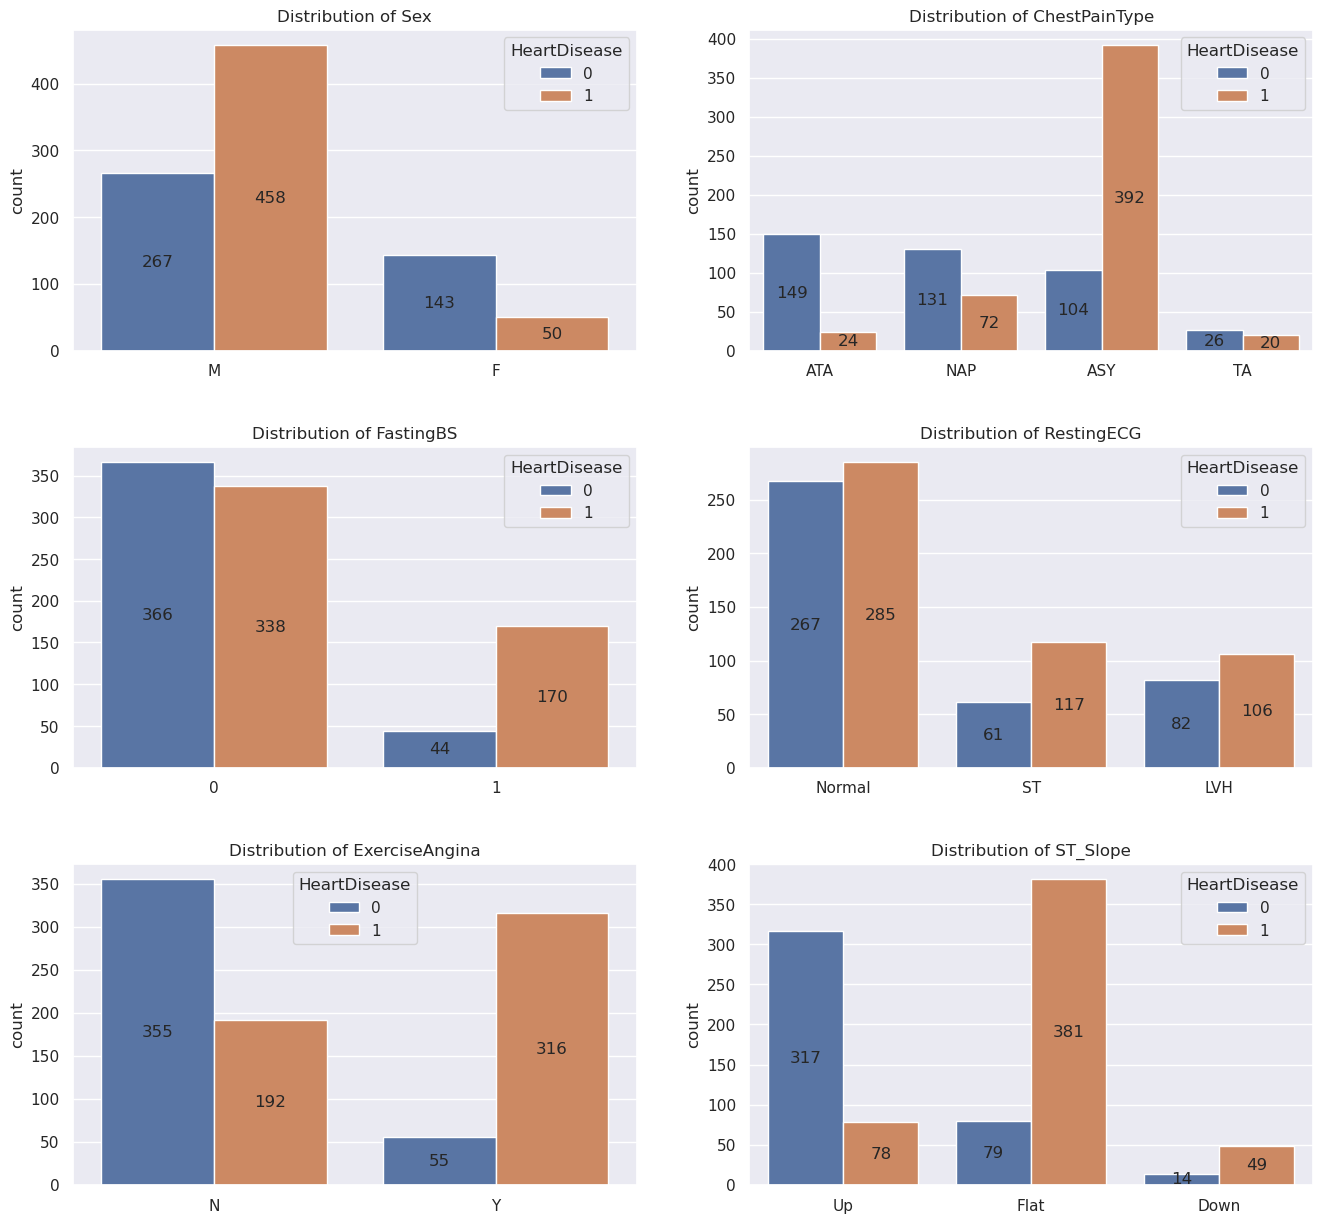

In [8]:
fig = plt.figure(figsize=(16,15))
sns.set_theme()
for ind, cat in enumerate(cat_vars[:-1]):
    ax = fig.add_subplot(3,2,ind+1)
    sns.countplot(data=df, x=cat, ax=ax, hue='HeartDisease')
    for bar in ax.containers:
        ax.bar_label(bar, label_type='center')
    ax.set_title(f"Distribution of {cat}")
    ax.set_xlabel('')
#     print(cat)
    

plt.subplots_adjust(hspace=0.3)
plt.show()

The findings are as follows:
- Most of the patients with heart disease are male. Only 50 women have heart disease.
- A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, 316 were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, 381 were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

## Data Cleaning

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values RestingBP and Cholesterol contain and decide how to handle those.

In [9]:
print('Number of rows with zero RestingBP:', df.query('RestingBP == 0').shape[0])

Number of rows with zero RestingBP: 1


There is only one value of 0 in RestingBP we can remove this value.

In [10]:
#drop row with zero restingBP
df = df.drop(df.query('RestingBP == 0').index)

In [11]:
print('Number of rows with zero cholesterol', df.query('Cholesterol == 0').shape[0])

Number of rows with zero cholesterol 171


There are 172 zero values for Cholesterol. That's a relatively high number. Remove them all and replacing those values with the median might not be an ideal approach, but that's what i will do for now.

To be more accurate, I will replace the zero values in Cholesterol in relation to HeartDisease. So, the 0 values in Cholesterol for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And will do the same for those who were not diagnosed with a heart disease.

In [12]:
df_clean = df.copy()

#get meadian values for patients with heart disease and not
no_disease_val, disease_val = df_clean.groupby('HeartDisease').agg('median')['Cholesterol']

# create mask for no heart disease patients
mask = (df_clean['HeartDisease'] == 0) & (df_clean['Cholesterol'] == 0)

#replace cholesterol values no heart disease patients
df_clean.loc[mask, 'Cholesterol'] = no_disease_val

# create mask for heart disease patients
mask = (df_clean['HeartDisease'] == 1) & (df_clean['Cholesterol'] == 0)

#replace cholesterol values for heart disease patients
df_clean.loc[mask, 'Cholesterol'] = disease_val

In [13]:
df_clean[["Cholesterol", "RestingBP"]].describe()


,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


The minimum values for both have changed! There are no more zero values in either of those.

## Feature Selection


Thanks to our EDA and a general understanding of the features, identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`

I will use correlation to identify how stronly the feature columns are correlated to the target colummn. That should help to narrow down on the features.

In order to do that, lets convert our categorical columns into dummy variables.

In [14]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


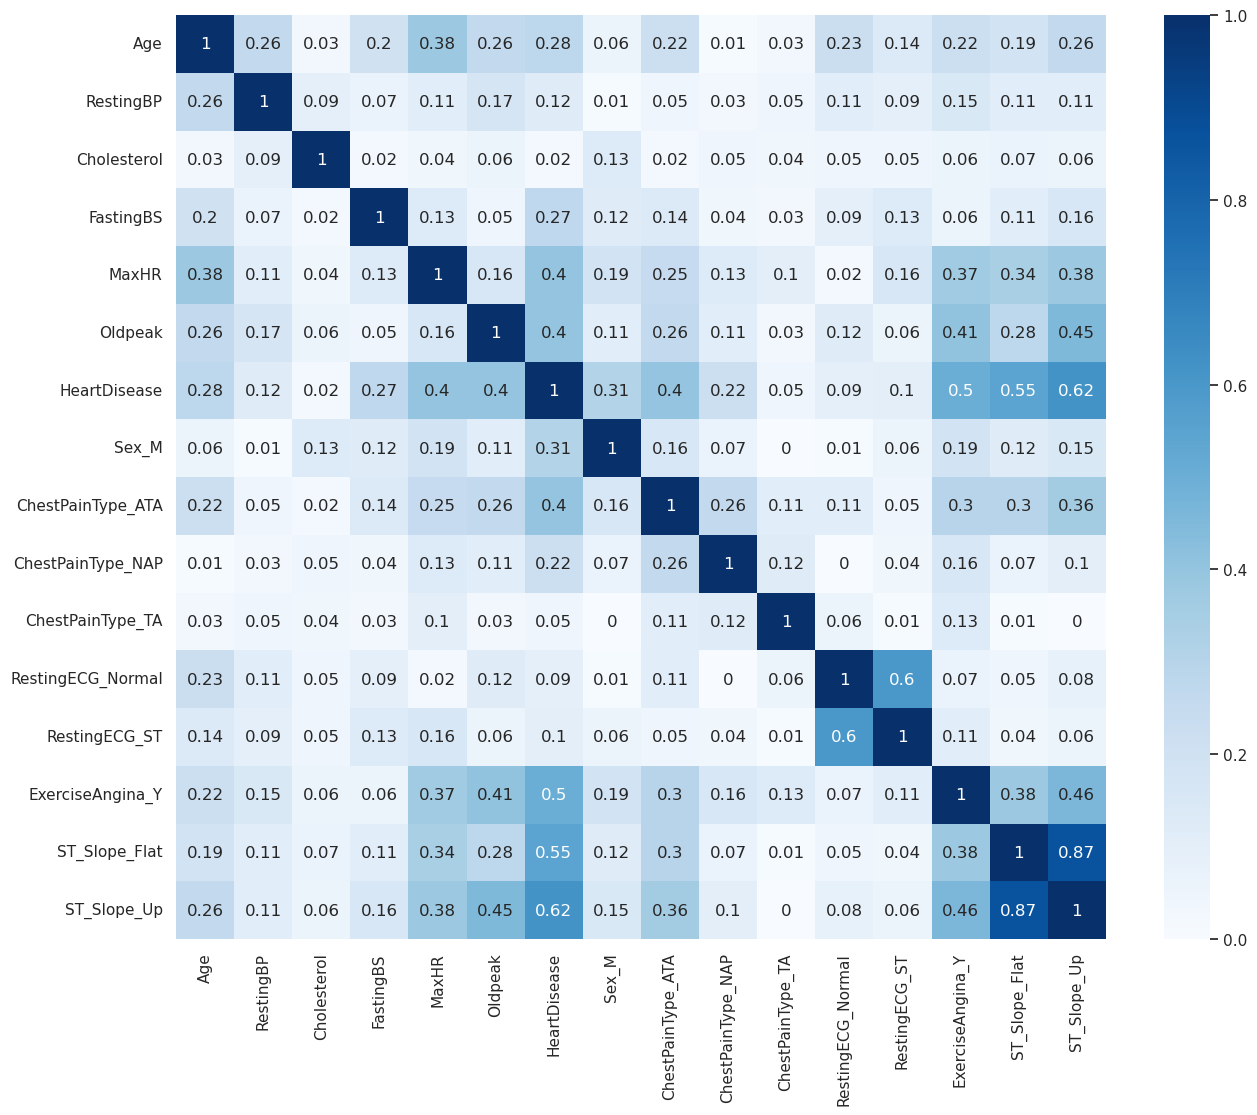

In [15]:
correlations = abs(round(df_clean.corr(),2))
plt.figure(figsize=(15,12))
fig.tight_layout()
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.show()

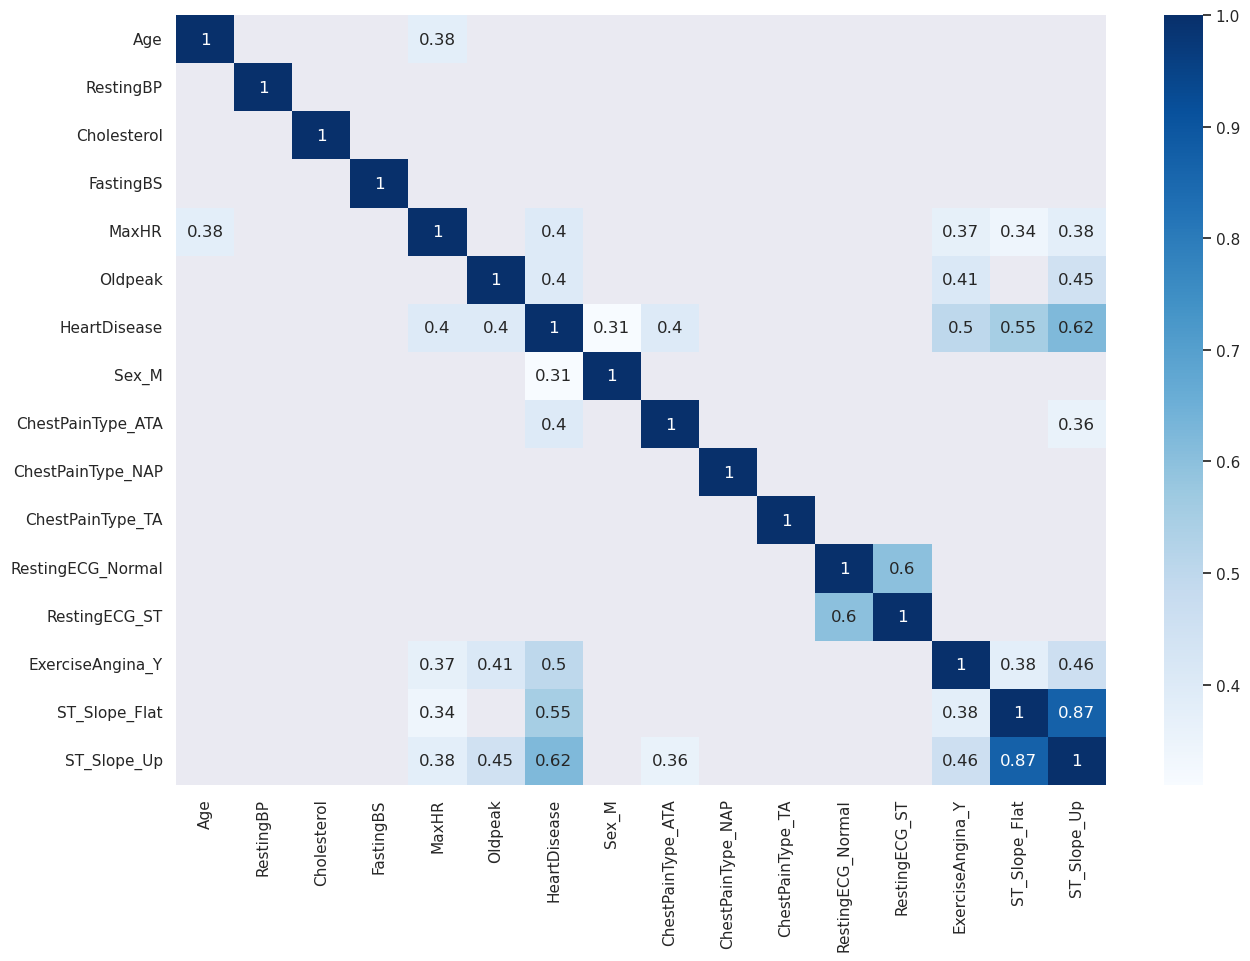

In [16]:
plt.figure(figsize=(15,10))
fig.tight_layout()
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap='Blues')
plt.show()

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to HeartDisease:

- `Oldpeak`
- `MaxHR`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, Cholesterol is not strongly correlated to HeartDisease. Right now it can be ignored feature for now.

Given everything we have attempted so far, the narrowed down features are the following:

- Oldpeak
- Sex_M
    - It has a relatively low value for the coefficient, but given what is observed in the EDA, let's also take it into account.
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

Time to create the model using these features!


## Building a Classifier with One Feature

Lets start by spliting our dataset into a training and a test set first.

In [17]:
X = df_clean.drop(['HeartDisease'], axis=1)
y = df_clean['HeartDisease']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

Start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.



In [18]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    score = knn.score(X_val[[feature]], y_val)
    print(f'The knn classifier trained on {feature} with neighbors=3 has an accuracy score of {score*100:.2f}%')

The knn classifier trained on Oldpeak with neighbors=3 has an accuracy score of 76.81%
The knn classifier trained on Sex_M with neighbors=3 has an accuracy score of 44.93%
The knn classifier trained on ExerciseAngina_Y with neighbors=3 has an accuracy score of 73.19%
The knn classifier trained on ST_Slope_Flat with neighbors=3 has an accuracy score of 81.88%
The knn classifier trained on ST_Slope_Up with neighbors=3 has an accuracy score of 84.06%


The best performing model, with an accuracy of ~84%, was trained on the ST_Slope_Up feature with ST_Slope_Flat being a close second. These make sense given the data distributions we saw previously.

Now lets train a model using all of these features next.

## Building a Classifier with Multiple Features

It's important to note that features are not yet normalized. Not all of the values are within the same range. To normalize variables need to be scaled.

In [19]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

In [20]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy = knn.score(X_val_scaled, y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 86.23


The model's accuracy jumped to ~86% That's some improvement. Using all these features results in an improved model. Nows lets check what parameters/hyperparameters might be optimal.

## Hyperparameter Optimization


Let's prepare the data first.


In [21]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

The params for the hyperparameters:

For k (n_neighbors in scikit-learn) will use values in the range of 1 to 20.
Use two distance metrics - `minkwoski` and `manhattan`.

In [22]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [23]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.56327543424318, {'metric': 'minkowski', 'n_neighbors': 19})

The best model had an accuracy of ~83% with 19 n_neighbors and minkowski as the distance metric.

The accuracy of this model is only slightly worse. Since GridSearchCV employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

Lets evaluate our model on our test set now.

## Model Evaluation on Test Set


In [24]:
#normalize test set
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 86.23


The model got an accuracy of ~86% meaning that the model is likely to correctly predict whether a patient is at risk for a heart disease ~87% of the time.

However, the accuracy being higher than the one before raises some flags. One explanation that could explain is to look at how the data is distributed.



In [25]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())


Distribution of patients by their sex in the entire dataset
1    724
0    193
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the training dataset
1    615
0    164
Name: Sex_M, dtype: int64

Distribution of patients by their sex in the test dataset
1    109
0     29
Name: Sex_M, dtype: int64


The model used `Sex` as one of the features for training the model.

- X had 724 males and 193 females.
- X_train had 615 males and 164 females.
- X_test had 109 males and 29 females.

It can be seen that the above datasets have a significantly higher number of male patients than female ones. This presents a bias and it can potentially impacts model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Summary and Next Steps
The final model was trained using the following features:

Oldpeak
Sex_M
ExerciseAngina_Y
ST_Slope_Flat
ST_Slope_Up
and had a test set accuracy of 86.23%. However, given the limitations of data this accuracy might not be indicative of a well performing model.

There are quite a few things that could be done next to get better results:

Try out different features.
Expand the grid search parameters to identify more optimal hyperparameters.
Explore other algorithms that might perform better than k-NN.
Try and collect more data.